In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
# # pip install tensorflow
!pip install keras==2.3.1
!pip install tensorflow==2.2

     |████████████████████████████████| 378kB 3.4MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


     |████████████████████████████████| 516.2MB 35kB/s 
     |████████████████████████████████| 3.0MB 38.9MB/s 
     |████████████████████████████████| 460kB 44.4MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
y


In [ ]:
content_text = '/content/drive/My Drive/flickr30k_images/results.csv'
cont = '/content/drive/My Drive/flickr30k_images/'
content = '/content/drive/My Drive/flickr30k_images/flickr30k_images/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_doc(filename):
	file = open(filename, encoding="utf8")
	text = file.read()
#     f = open(filename, encoding="utf8")
	file.close()
	return text

filename = content_text
# load the descriptions of images
doc = load_doc(filename)
#print discriptions of a specific image
print(doc[39:250])

doc = doc[39:]
print()
print(doc[:300])

0092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg| 1| Two young , White males are outside near many bushes .
1000092795.jpg| 2| Two men in green s

0092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg| 1| Two young , White males are outside near many bushes .
1000092795.jpg| 2| Two men in green shirts are standing in a yard .
1000092795.jpg| 3| A man in a blue shirt standing in a gar


In [ ]:
def load_descriptions(doc):
	descriptions  = dict()
	for line in doc.split('\n'):
		tokens = line.split('|')
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[2:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create a list if needed
		if image_id not in descriptions:
			descriptions [image_id] = list()
		# save  captions of the images
		descriptions[image_id].append(image_desc)
	return descriptions 

# get the descriptions of the images
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 31784 


In [ ]:
# print(list(descriptions.keys())[:5])
# # descriptions = descriptions[1:]
# # print(list(descriptions.keys())[:5])

['0092795', '1000092795', '10002456', '1000268201', '1000344755']


In [ ]:
# print(descriptions['1000366164'])

# print(descriptions['3664750995'])

[' Two men , one in a gray shirt , one in a black shirt , standing near a stove .', ' Two guy cooking and joking around with the camera .', ' Two men in a kitchen cooking food on a stove .', ' Two men are at the stove preparing food .', ' Two men are cooking a meal .']
[' Small Asian girl and boy running towards the camera in the opposite direction of the other people .', ' Two small children , a boy and a girl , are running down a path that has columns on either side .', ' A girl and boy are running towards the camera while several people walk around them .', ' A young boy and girl run through a walkway between buildings .', ' Two young children running down a busy walkway .']


In [ ]:
import string
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			desc = desc.split()
			desc = [word.lower() for word in desc]
			# remove punctuation from each word
			desc = [w.translate(table) for w in desc]
			# remove words that contain 1 letter
			desc = [word for word in desc if len(word)>1]
			# remove words that have non alohapitic chars
			desc = [word for word in desc if word.isalpha()]
			# join the sentence back
			desc_list[i] =  ' '.join(desc)

# clean the captions
clean_descriptions(descriptions)

In [ ]:
print(descriptions['1000366164'])

print(descriptions['1000092795'])

['two men one in gray shirt one in black shirt standing near stove', 'two guy cooking and joking around with the camera', 'two men in kitchen cooking food on stove', 'two men are at the stove preparing food', 'two men are cooking meal']
['two young white males are outside near many bushes', 'two men in green shirts are standing in yard', 'man in blue shirt standing in garden', 'two friends enjoy time spent together']


In [ ]:
# Create a vocabulary of all the unique words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 19735


In [ ]:
# # save captions to file, one per line
# def save_descriptions(descriptions, filename):
# 	lines = list()
# 	for key, desc_list in descriptions.items():
# 		for desc in desc_list:
# 			lines.append(key + ' ' + desc)
# 	data = '\n'.join(lines)
# 	file = open(filename, 'w')
# 	file.write(data)
# 	file.close()

# save_descriptions(descriptions, 'descriptions_30k.txt')

In [ ]:
# get the names of the training set images 
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [ ]:
# print(content)
images = '/content/drive/My Drive/flickr30k_images/flickr30k_images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
# print(img)
# print(len(img), len(images))

In [ ]:
print(len(img))
print(img[:2])

31783
['/content/drive/My Drive/flickr30k_images/flickr30k_images/7802432164.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/7847188372.jpg']


In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

In [ ]:
# from sklearn.model_selection import train_test_split

# s = pd.Series(descriptions)
# train_data , test_data  = [i.to_dict() for i in train_test_split(s, train_size=0.8)]

In [ ]:
# print(len(test_data), len(train_data), len(test_data) + len(train_data))
# print(test_data.keys())

6357 25427 31784
dict_keys(['6090223025', '873933926', '6999996105', '1316505120', '81788174', '3133403457', '3003612178', '116569042', '4968323199', '3335127933', '2398466720', '5024991277', '4975568426', '181600316', '3116039960', '2399674240', '3623047508', '1944940887', '2476503534', '4857153551', '328322290', '5377361', '2141692397', '4949430092', '324642762', '4682801730', '111671162', '7631372276', '5622966650', '439569646', '6927848734', '3525403875', '141372871', '8154861953', '3821671043', '449377293', '1496935683', '4962648530', '2666179615', '4718145266', '3312232591', '7481274404', '313342543', '4971484184', '3648097366', '244360246', '3062433945', '409930622', '3030079705', '7761586286', '358779007', '1146938063', '7724666074', '7632093958', '2435518586', '4768451314', '732001349', '1398766312', '3253174263', '2101738845', '836828001', '3300643106', '6556863679', '394463341', '3470129475', '2249912075', '3251906388', '4758565051', '4474749623', '4873542302', '313326614', 

In [ ]:
# Extra when .pkl file is used first


train_features = load(open(cont + "encoded_train_images_30k_1.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

test_features = load(open(cont + "encoded_test_images_30k_1.pkl", "rb"))
print('Photos: train=%d' % len(test_features))
# print(test_features)

Photos: train=25426
Photos: train=6357


In [ ]:
# # train_images_file = content + 'Flickr_TextData/Flickr_8k.trainImages.txt'
# # # Read the training images names
# # train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# # # print(len(train_images), train_images)

# train_img = []
# for val in train_data.keys():
#     train_img.append(content + val + ".jpg")
# # img1 = []
# # for i in img:
# #     img1.append(i.split('/')[-1:])

# # img2 = set()
# # for i in img1:
# #     val = str(i).split('.')
# #     img2.add(str(val[0][2:]))

# # for i in img2: 
# #     if i in train_images: # if the image belongs to training set
# #         train_img.append(content + '/Images/'+ str(i)+'.jpg')
# print(len(train_img), train_img)

In [ ]:
train_img = []
for val in train_features.keys():
    train_img.append(cont + val)

print(len(train_img), train_img)

25426 ['/content/drive/My Drive/flickr30k_images/flickr30k_images/5826148145.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4612135887.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/5057010159.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4728581339.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/2103077124.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4451567464.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/3116379964.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/1296395998.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/3430526230.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/252846811.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4835656519.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4789309483.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4686133452.jpg', '/cont

In [ ]:
# with open("train_img_30k.txt", "w") as output:
#     output.write(str(train_img))

In [ ]:
# train_img = load_doc('train_img_30k.txt')

In [ ]:
# test_img = []
# for val in test_data.keys():
#     test_img.append(content + val + ".jpg")

# print(len(test_img), test_img)

6357 ['/content/drive/My Drive/flickr30k_images/flickr30k_images/6090223025.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/873933926.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/6999996105.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/1316505120.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/81788174.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/3133403457.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/3003612178.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/116569042.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4968323199.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/3335127933.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/2398466720.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/5024991277.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4975568426.jpg', '/content/

In [ ]:
test_img = []
for val in test_features.keys():
    test_img.append(content + val)

print(len(test_img), test_img)

6357 ['/content/drive/My Drive/flickr30k_images/flickr30k_images/86112808.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4648122589.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/3859203305.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/6031795624.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/86734276.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/492493570.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/1804144683.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/6086510173.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4463883091.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/2737729252.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/2282522980.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/102268204.jpg', '/content/drive/My Drive/flickr30k_images/flickr30k_images/4792185041.jpg', '/content/dr

In [ ]:
# with open("test_img_30k.txt", "w") as output:
#     output.write(str(test_img))

In [ ]:
# test_img = load_doc('test_img_30k.txt')

In [ ]:
# # load training dataset
# # filename = content + 'Flickr_TextData/Flickr_8k.trainImages.txt'
# train = []
# for key in train_data.keys():
#     train.append(key)
# print('Dataset: %d' % len(train))
# print(train)

In [ ]:
train = []
for key in train_features.keys():
  val1, val2 = key.split('/')
  train.append(val2.split('.')[0])
print('Dataset: %d' % len(train))
print(train)

Dataset: 25426
['5826148145', '4612135887', '5057010159', '4728581339', '2103077124', '4451567464', '3116379964', '1296395998', '3430526230', '252846811', '4835656519', '4789309483', '4686133452', '3352577815', '3906158504', '3496410435', '6032303452', '2289751916', '2396746868', '2899276965', '6398988', '4097554482', '2136080450', '2938431292', '263491786', '4917939779', '4771254001', '3444684583', '4567734402', '4862594943', '3579150322', '3142675162', '2068403258', '2695093520', '2475959402', '2555638166', '4436781562', '2360194369', '3457210101', '1386973587', '1018057225', '1472653060', '3190677999', '262642489', '532756526', '2089442007', '98492339', '5453936030', '1359101233', '3258391809', '2268115375', '5710857189', '4817935794', '4904155688', '3591170729', '3731803474', '2572812372', '235065283', '4107333458', '4649915901', '3560726559', '3504479370', '6988222785', '4710757099', '2217258342', '2541939817', '508264241', '4621699159', '3651107058', '2705888144', '2206284983', '

In [ ]:
# with open("train_30k.txt", "w") as output:
#     output.write(str(train))

In [ ]:
# train = load_doc('train_30k.txt')

In [ ]:
# test = []
# for key in test_data.keys():
#   test.append(key)
# print('Dataset: %d' % len(test))
# print(test)

Dataset: 6357
['6090223025', '873933926', '6999996105', '1316505120', '81788174', '3133403457', '3003612178', '116569042', '4968323199', '3335127933', '2398466720', '5024991277', '4975568426', '181600316', '3116039960', '2399674240', '3623047508', '1944940887', '2476503534', '4857153551', '328322290', '5377361', '2141692397', '4949430092', '324642762', '4682801730', '111671162', '7631372276', '5622966650', '439569646', '6927848734', '3525403875', '141372871', '8154861953', '3821671043', '449377293', '1496935683', '4962648530', '2666179615', '4718145266', '3312232591', '7481274404', '313342543', '4971484184', '3648097366', '244360246', '3062433945', '409930622', '3030079705', '7761586286', '358779007', '1146938063', '7724666074', '7632093958', '2435518586', '4768451314', '732001349', '1398766312', '3253174263', '2101738845', '836828001', '3300643106', '6556863679', '394463341', '3470129475', '2249912075', '3251906388', '4758565051', '4474749623', '4873542302', '313326614', '3437315443',

In [ ]:
# test = []
# for key in test_features.keys():
#   key = key.split('.')[0]
#   key = key.split('/')[1]
#   test.append(key)
# print('Dataset: %d' % len(test))
# print(test)

test = []
for key in test_features.keys():
  test.append(key.split('.')[0])
print('Dataset: %d' % len(test))
print(test)

Dataset: 6357
['86112808', '4648122589', '3859203305', '6031795624', '86734276', '492493570', '1804144683', '6086510173', '4463883091', '2737729252', '2282522980', '102268204', '4792185041', '751074141', '1483804641', '1225603792', '4729191874', '4859477805', '15965185', '3012229', '3195320645', '258434606', '5523249598', '150710406', '340027203', '3009035153', '8077305139', '7013217', '183502317', '3931111565', '4850734257', '3047749814', '4381281855', '2266142543', '3298106624', '3341077091', '2381937867', '50735095', '8243477528', '63108800', '4232753024', '1425069590', '3471117376', '3483071906', '2645175777', '2862721322', '2502250148', '2188790173', '2396096161', '1577697374', '1980882959', '530472459', '5870701819', '5415070045', '19245206', '3150659152', '1558272464', '2241328814', '4480923732', '3855557050', '7130336193', '3444982197', '3389448506', '16158623', '2884092603', '816981408', '1363924449', '3635911776', '4430517017', '2616643090', '292887910', '3319058642', '271170

In [ ]:
# with open("test_30k.txt", "w") as output:
#     output.write(str(test))

In [ ]:
# test = load_doc('test_30k.txt')

In [ ]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

In [ ]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[2:]
		# skip images not in the set
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# Add start tag before the descriptions and end tag after the descriptions
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

train_descriptions = load_clean_descriptions(cont + 'descriptions_30k.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=25426


In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the InceptionResNetV2  model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from InceptionResNetV2 model
    x = preprocess_input(x)
    return x

In [ ]:
# Load the InceptionResNetV2 model
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

model = InceptionResNetV2(weights='imagenet')

In [ ]:
# Create a new model, by removing the last layer (output Fullyconnected layer) from the InceptionResNetV2
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


In [ ]:
# # convert all the train images into a vector of size (2048, )
# # Execute only once
# start = time()
# encoding_train = {}

# count = 0
# for img in train_img:
#     encoding_train[img] = encode(img)
#     count += 1
#     if(count%100 == 0):
#         print(count)
        
# print("Time taken in seconds =", time()-start)

In [ ]:
# import _pickle as cPickle

# with open("encoded_train_images_30k_1.pkl", "wb") as encoded_pickle:
#     cPickle.dump(encoding_train, encoded_pickle)

In [ ]:
# # Call the funtion to encode all the test images - Execute this only once
# start = time()
# encoding_test = {}

# count = 0

# for img in test_img:
#     encoding_test[img[len(images):]] = encode(img)
#     count += 1
#     if(count%100 == 0):
#         print(count)
        
# print("Time taken in seconds =", time()-start)

In [ ]:
# # Save the test features to file
# with open("encoded_test_images_30k_1.pkl", "wb") as encoded_pickle:
#     cPickle.dump(encoding_test, encoded_pickle)

In [ ]:
# train_features = load(open(cont + "encoded_train_images_30k_1.pkl", "rb"))
# print('Photos: train=%d' % len(train_features))

Photos: train=25426


In [ ]:
# print(train_features['flickr30k_images/3005124440.jpg'])

In [ ]:
# count = 0
# for key in train_features.keys():
#     print(key)
#     count += 1
#     if count > 10:
#         break

flickr30k_images/5826148145.jpg
flickr30k_images/4612135887.jpg
flickr30k_images/5057010159.jpg
flickr30k_images/4728581339.jpg
flickr30k_images/2103077124.jpg
flickr30k_images/4451567464.jpg
flickr30k_images/3116379964.jpg
flickr30k_images/1296395998.jpg
flickr30k_images/3430526230.jpg
flickr30k_images/252846811.jpg
flickr30k_images/4835656519.jpg


In [ ]:
# test_features = load(open(cont + "encoded_test_images_30k_1.pkl", "rb"))
# print('Photos: train=%d' % len(test_features))
# # print(test_features)

Photos: train=6357


In [ ]:
# count = 0
# for key in test_features.keys():
#     print(key)
#     count += 1
#     if count > 10:
#         break

86112808.jpg
4648122589.jpg
3859203305.jpg
6031795624.jpg
86734276.jpg
492493570.jpg
1804144683.jpg
6086510173.jpg
4463883091.jpg
2737729252.jpg
2282522980.jpg


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

127130

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 17552 -> 4699


In [ ]:

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
wordtoix

{'startseq': 1,
 'in': 2,
 'pink': 3,
 'dress': 4,
 'is': 5,
 'climbing': 6,
 'up': 7,
 'set': 8,
 'of': 9,
 'stairs': 10,
 'an': 11,
 'way': 12,
 'endseq': 13,
 'girl': 14,
 'going': 15,
 'into': 16,
 'wooden': 17,
 'cabin': 18,
 'the': 19,
 'to': 20,
 'her': 21,
 'playhouse': 22,
 'building': 23,
 'men': 24,
 'one': 25,
 'gray': 26,
 'shirt': 27,
 'black': 28,
 'standing': 29,
 'near': 30,
 'stove': 31,
 'guy': 32,
 'cooking': 33,
 'and': 34,
 'around': 35,
 'with': 36,
 'camera': 37,
 'kitchen': 38,
 'food': 39,
 'on': 40,
 'are': 41,
 'at': 42,
 'preparing': 43,
 'meal': 44,
 'people': 45,
 'photo': 46,
 'playing': 47,
 'guitar': 48,
 'other': 49,
 'poking': 50,
 'him': 51,
 'green': 52,
 'holds': 53,
 'while': 54,
 'man': 55,
 'observes': 56,
 'his': 57,
 'fixing': 58,
 'players': 59,
 'costume': 60,
 'another': 61,
 'coat': 62,
 'two': 63,
 'boys': 64,
 'sits': 65,
 'chair': 66,
 'holding': 67,
 'large': 68,
 'stuffed': 69,
 'animal': 70,
 'lion': 71,
 'sitting': 72,
 'completes'

In [ ]:
ixtoword

{1: 'startseq',
 2: 'in',
 3: 'pink',
 4: 'dress',
 5: 'is',
 6: 'climbing',
 7: 'up',
 8: 'set',
 9: 'of',
 10: 'stairs',
 11: 'an',
 12: 'way',
 13: 'endseq',
 14: 'girl',
 15: 'going',
 16: 'into',
 17: 'wooden',
 18: 'cabin',
 19: 'the',
 20: 'to',
 21: 'her',
 22: 'playhouse',
 23: 'building',
 24: 'men',
 25: 'one',
 26: 'gray',
 27: 'shirt',
 28: 'black',
 29: 'standing',
 30: 'near',
 31: 'stove',
 32: 'guy',
 33: 'cooking',
 34: 'and',
 35: 'around',
 36: 'with',
 37: 'camera',
 38: 'kitchen',
 39: 'food',
 40: 'on',
 41: 'are',
 42: 'at',
 43: 'preparing',
 44: 'meal',
 45: 'people',
 46: 'photo',
 47: 'playing',
 48: 'guitar',
 49: 'other',
 50: 'poking',
 51: 'him',
 52: 'green',
 53: 'holds',
 54: 'while',
 55: 'man',
 56: 'observes',
 57: 'his',
 58: 'fixing',
 59: 'players',
 60: 'costume',
 61: 'another',
 62: 'coat',
 63: 'two',
 64: 'boys',
 65: 'sits',
 66: 'chair',
 67: 'holding',
 68: 'large',
 69: 'stuffed',
 70: 'animal',
 71: 'lion',
 72: 'sitting',
 73: 'comple

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

4700

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most common words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum word length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 73


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # get the photo feature
            photo = photos['flickr30k_images/' + key +'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence to reach the max length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
pip install flair

In [ ]:
import flair
from flair.embeddings import BertEmbeddings

In [ ]:
bert_embeddings = BertEmbeddings('bert-base-uncased')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  """Entry point for launching an IPython kernel.


In [ ]:
# import torch
# from flair.data import Sentence
# embedding_matrix = np.zeros((127130, 3072))

# mylist = []
# count = 0
# for key, desc_list in descriptions.items():
#     if count%100 == 0:
#         print(count)
#     count += 1
#     for desc in desc_list:
#         mysent = Sentence(desc, use_tokenizer=True)
#         bert_embeddings.embed(mysent)
#         i=0
#         if(i < 127129):
#             for token in mysent:
#                 # mylist.append(torch.cat([token.embedding.unsqueeze(0) for token in mysent], dim=0))
#                 # mylist.append([token, token.embedding])
#                 embedding_matrix[i] = token.embedding
#                 i+=1
#                 # print(token.embedding)
# #                 print("matrix")
# #                 print(embedding_matrix)
#         else:
#             break

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
2020-11-10 02:42:59,024 Warning: An empty Sentence was created! Are there empty strings in your dataset?
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700

In [ ]:
embedding_matrix.shape

NameError: ignored

In [ ]:
# # save numpy array as csv file
# from numpy import asarray
# from numpy import savetxt
# # define data

# # save to csv file
# savetxt(cont + 'embedding_matrix_30k.csv', embedding_matrix, delimiter=',')

In [ ]:

# # save numpy array as npy file
# from numpy import asarray
# from numpy import save
# # define data
# data = embedding_matrix
# # save to npy file
# save(cont + 'embedding_matrix_30k.npy', data)

In [ ]:

# load numpy array from npy file
from numpy import load
# load array
embedding_matrix = load(cont + 'embedding_matrix_30k.npy')

In [ ]:
# count = 5
# for key, des in descriptions.items():
#     print(key)
#     for desc in des:
#         print(desc)
#     count += 1
#     if count > 50:
#         break

1000092795
two young guys with shaggy hair look at their hands while hanging out in the yard
two young white males are outside near many bushes
two men in green shirts are standing in yard
man in blue shirt standing in garden
two friends enjoy time spent together
10002456
several men in hard hats are operating giant pulley system
workers look down from up above on piece of equipment
two men working on machine wearing hard hats
four men on top of tall structure
three men on large rig
1000268201
child in pink dress is climbing up set of stairs in an entry way
little girl in pink dress going into wooden cabin
little girl climbing the stairs to her playhouse
little girl climbing into wooden playhouse
girl going into wooden building
1000344755
someone in blue shirt and hat is standing on stair and leaning against window
man in blue shirt is standing on ladder cleaning window
man on ladder cleans the window of tall building
man in blue shirt and jeans on ladder cleaning windows
man on ladder

In [ ]:
# checkpoint_path = "training_1.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
embedding_matrix[72:90]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
embedding_matrix[70:90]

array([[-0.13035499, -0.19972563,  0.31226978, ..., -0.26094052,
        -0.11528123,  0.05280687],
       [-0.60515022, -0.55827147, -0.62738675, ...,  0.06626671,
         0.59551293, -0.72395718],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
inputs1 = Input(shape=(1536,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,)) #Text
se1 = Embedding(127130, 3072, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 73)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 73, 3072)     390543360   input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1536)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 73)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 73, 3072)     390543360   input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1536)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
print(steps)

8475


In [ ]:
model.load_weights(cont + 'model_bert_30k0.h5')

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(cont + 'model_bert_30k' + str(i+1) + '.h5')

Epoch 1/1
8475/8475 [==============================] - 32464s 4s/step - loss: 4.5911
Epoch 1/1
 146/8475 [..............................] - ETA: 8:57:02 - loss: 4.3108

In [ ]:
model.load_weights(cont + 'model_bert_30k0.h5')

NameError: ignored

In [ ]:
with open(cont + "encoded_test_images_30k_1.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle,allow_pickle=True)

In [ ]:
e = encoding_test['6155570605.jpg']
e

array([0.07375   , 0.3577755 , 0.36330658, ..., 0.1693311 , 0.65395534,
       0.19310386], dtype=float32)

In [ ]:
content = '/content/drive/My Drive/flickr30k_images/flickr30k_images/'
images = content

def predict_captions(image):
    start_word = ['startseq']
    while True:
        par_caps = [wordtoix[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_length, padding='post')
        image = image.split('/')[-1]
        e = encoding_test[image]
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = ixtoword[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred ==  'endseq' or len(start_word) > max_length:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
# Load the InceptionResNetV2 model
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

model_image = InceptionResNetV2(weights='imagenet')

# Create a new model, by removing the last layer (output Fullyconnected layer) from the InceptionResNetV2
model_new = Model(model_image.input, model_image.layers[-2].output)


def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# content = '/content/drive/My Drive/flickr30k_images/flickr30k_images/'
# images = content

def predict_captions(image):
    start_word = ['startseq']
    while True:
        par_caps = [wordtoix[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_length, padding='post')
        e = encode(image)
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = ixtoword[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred ==  'endseq' or len(start_word) > max_length:
            break
            
    return ' '.join(start_word[1:-1])

/content/drive/My Drive/flickr30k_images/flickr30k_images/6155570605.jpg <class 'str'>


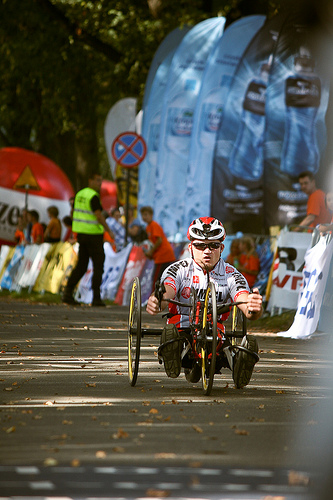

In [ ]:
test_image = test_img[80]
print(test_image, type(test_image))
Image.open(test_image)

In [ ]:
print ('Prediction:', predict_captions(test_image))

Prediction: in blue is riding bike bike


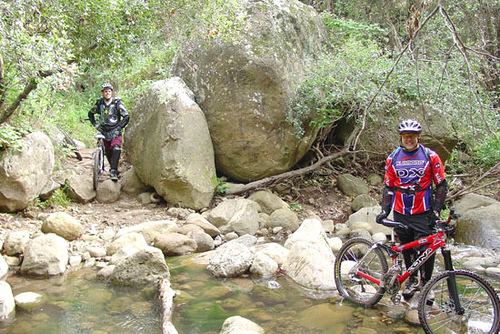

In [ ]:
test_image = test_img[1001]
Image.open(test_image)

In [ ]:
print ('Prediction:', predict_captions(test_image))

Prediction: in red is riding on the side


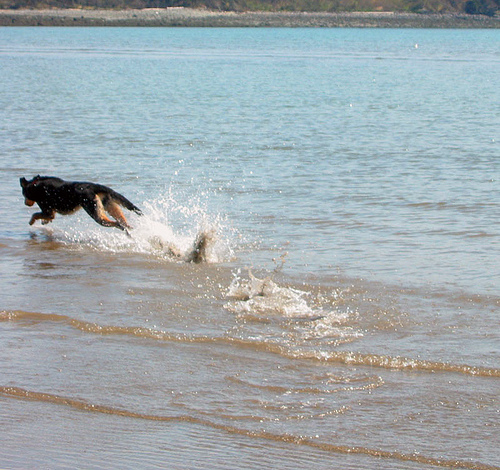

In [ ]:
test_image = test_img[952]
Image.open(test_image)

In [ ]:
print ('Prediction:', predict_captions(test_image))

Prediction: dog is jumping through the water
